In [715]:
import scipy, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
sys.path.append("/Users/alex/Desktop/Fabry-Perot/modelling")
sys.path.append(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\modelling")
sys.path.append(r"C:\Users\ge85rek\Desktop\Fabry-Perot\modelling")
import read_csv, T_and_R

In [716]:
data = read_csv.read_csv(r"/Users/alex/Desktop/Fabry-Perot/data/InGaN_FTIR.csv") #MacOS
#data = read_csv.read_csv(r"C:\Users\ge85rek\Desktop\Fabry-Perot\data\InGaN_FTIR.csv") #Labor
#data = read_csv.read_csv(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\data\InGaN_FTIR.csv") # PC
# von cm zu m 
frequenz = scipy.constants.c * np.array(data[0][::-1]) * 100
wavelength = scipy.constants.c/frequenz

In [717]:
# return index of a sorted list wherelist[index] is a specific value
def find_nearest(array, value):
    array = np.asarray(array)
    end = (np.abs(array - value)).argmin()
    return end

def flatten(data, N = 1200, cutdown = None, cutup = None):
    smooth = np.convolve(data, np.ones(N)/N, mode='same')
    return smooth[cutdown:cutup], data[cutdown:cutup]-smooth[cutdown:cutup]

def länge(m,n,f):
    lam = scipy.constants.c/f
    return m * lam / (2 * n)

def calculate_m(min_frequenz_array):
    lambda_array = [scipy.constants.c/f for f in min_frequenz_array]
    m_array = []
    for i in range(0,len(lambda_array)-1):
        m_array.append(lambda_array[i+1]/(lambda_array[i]-lambda_array[i+1]))
    return m_array

def calculate_m_looking_back(min_frequenz_array):
    lambda_array = [scipy.constants.c/f for f in min_frequenz_array]
    m_array = []
    for i in range(1,len(lambda_array)):
        m_array.append(lambda_array[i-1]/(lambda_array[i-1]-lambda_array[i]))
    return m_array

def polynomial(x,a0,a1,a2,a3,a4):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 

def sine(x,k,A,phi):
    return A*np.sin(k*x-phi)

def refractive_index(m,L,f):
    wavelength = scipy.constants.c/f
    n = (m * wavelength) / (2 * L)
    return n 

def fit_individually(xlim_lower_value,xlim_upper_value,x_dataset,y_dataset, p0 = [1,1,1,1,1]):
    x_lim_lower = find_nearest(x_dataset,xlim_lower_value)
    x_lim_upper = find_nearest(x_dataset,xlim_upper_value)
    x_data_modified = x_dataset[x_lim_lower:x_lim_upper]
    y_data_modified = y_dataset[x_lim_lower:x_lim_upper]
    params_fit, cov_fit = scipy.optimize.curve_fit(polynomial,x_data_modified,y_data_modified, p0 = p0)
    fitfunc = polynomial(x_data_modified,*params_fit)
    min_fit_index = scipy.signal.argrelmin(fitfunc, order = 500)
    min_fit_frequenz = x_data_modified[min_fit_index]
    min_fit_absorption = fitfunc[min_fit_index]
    plt.plot(x_data_modified,y_data_modified)
    plt.plot(min_fit_frequenz,min_fit_absorption, "ro")
    plt.plot(x_data_modified,fitfunc)
    return min_fit_frequenz, min_fit_absorption


# Fitting a Polynomial to each minimum individually for 20C

In [718]:
cutdown = find_nearest(frequenz, 0.7e14)
cutup = find_nearest(frequenz, 2.0e14)
ends = 600
frequenz_20_cut = frequenz[cutdown:cutup]
frequenz_20_no_edge = frequenz[cutdown+ends:cutup-ends]
data_J13_20 = data[8][::-1][cutdown:cutup]
data_J13_20_no_edge = data_J13_20[ends:-ends]
J13_20_smooth, J13_20_smoothed_out = flatten(data_J13_20, N = 1200)
J13_20_smooth_no_edge = J13_20_smooth[ends:-ends]
J13_20_smoothed_out_no_edge = J13_20_smoothed_out[ends:-ends]

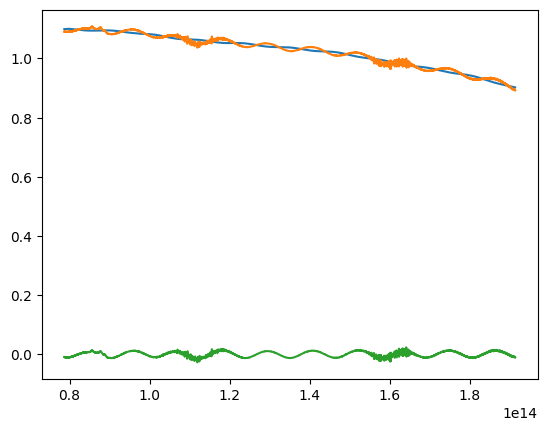

In [719]:
plt.plot(frequenz_20_no_edge, J13_20_smooth_no_edge)
plt.plot(frequenz_20_no_edge, data_J13_20_no_edge)
plt.plot(frequenz_20_no_edge, J13_20_smoothed_out_no_edge)

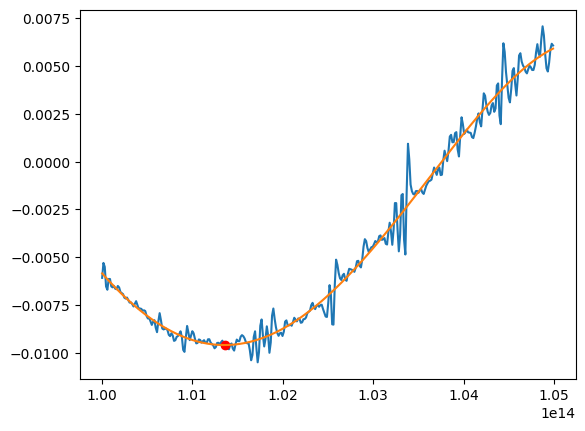

In [720]:
min_frequenz_first, min_absorption_first = fit_individually(1e14,1.05e14,frequenz_20_no_edge,J13_20_smoothed_out_no_edge)

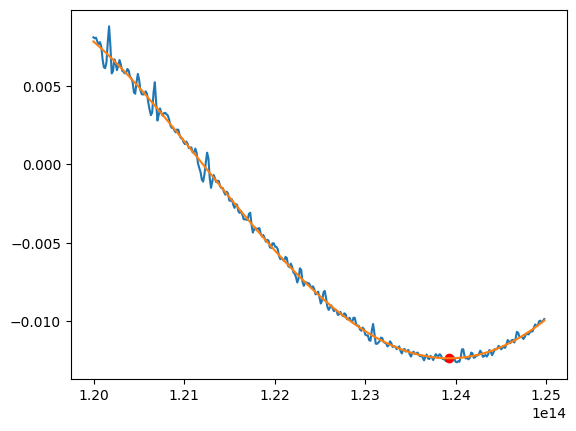

In [721]:
min_frequenz_second, min_absorption_second = fit_individually(1.2e14,1.25e14,frequenz_20_no_edge,J13_20_smoothed_out_no_edge)

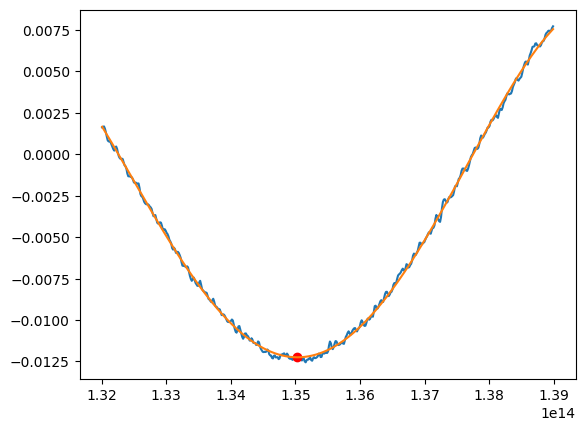

In [722]:
min_frequenz_third, min_absorption_third = fit_individually(1.32e14,1.39e14,frequenz_20_no_edge,J13_20_smoothed_out_no_edge)

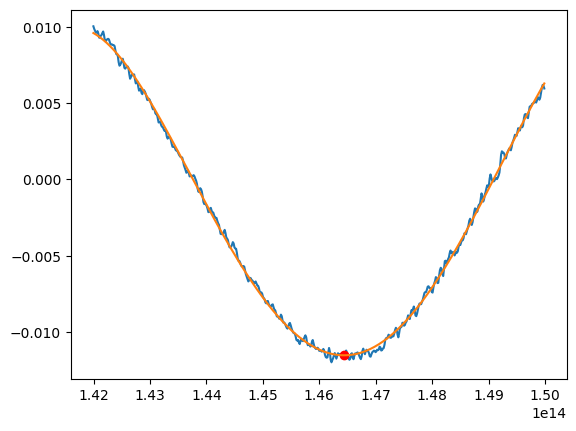

In [723]:
min_frequenz_fourth, min_absorption_fourth = fit_individually(1.42e14,1.5e14,frequenz_20_no_edge,J13_20_smoothed_out_no_edge)

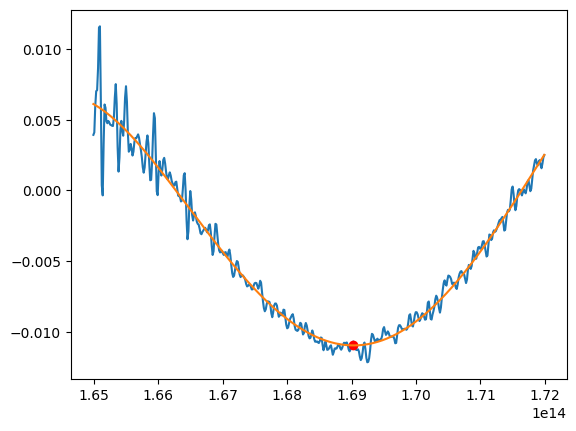

In [724]:
min_frequenz_fifth, min_absorption_fifth = fit_individually(1.65e14,1.72e14,frequenz_20_no_edge,J13_20_smoothed_out_no_edge)

In [725]:
min_frequenz_total = [min_frequenz_first[0], min_frequenz_second[0], min_frequenz_third[0], min_frequenz_fourth[0], min_frequenz_fifth[0]]
min_absorption_total = [min_absorption_first[0], min_absorption_second[0] , min_absorption_third[0],min_absorption_fourth[0], min_absorption_fifth[0]]

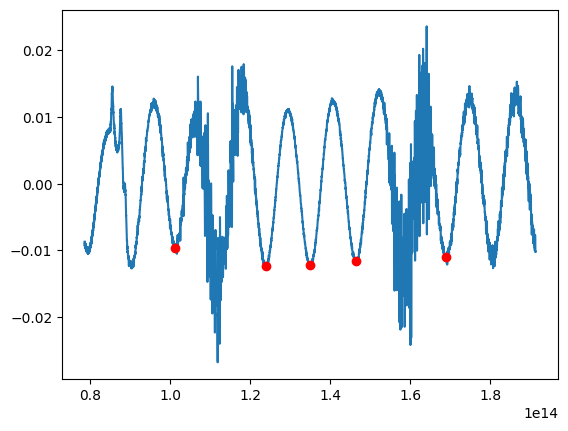

In [726]:
plt.plot(frequenz_20_no_edge,J13_20_smoothed_out_no_edge)
plt.plot(min_frequenz_total,min_absorption_total, "ro")

In [727]:
m_array_total = calculate_m(min_frequenz_total)
m_array_total

[4.4919923128201225, 11.162760412535178, 11.839036734468266, 6.481126044639499]

In [728]:
m_array_clean = np.arange(9,16)
m_array_clean = np.delete(m_array_clean, [1,5])
m_array_clean

array([ 9, 11, 12, 13, 15])

In [729]:
n_array = []
for i in range(0,len(m_array_clean)):
    n_array.append(refractive_index(m_array_clean[i], 3.5e-6, min_frequenz_total[i]))
n_array

[3.8027097513846,
 3.801477617664955,
 3.806102241175261,
 3.8021258093865584,
 3.800650072005824]

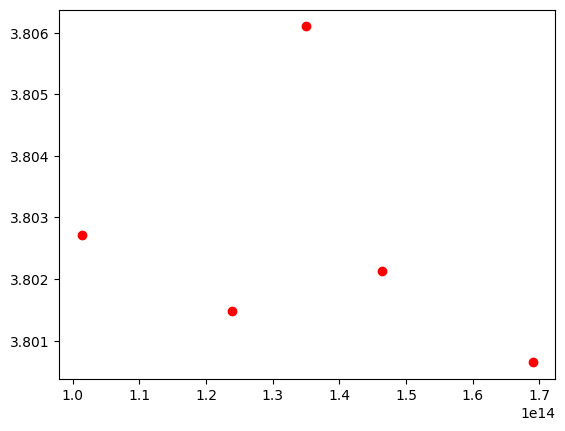

In [730]:
plt.plot(min_frequenz_total,n_array, "ro")

In [731]:
params_fit, cov_fit = scipy.optimize.curve_fit(polynomial,min_frequenz_total,n_array, p0 = [1,1,1,1,1])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [732]:
params_fit

array([ 1.31438601e+01, -2.85544573e-13,  3.23244747e-27, -1.60686574e-41,
        2.96080312e-56])

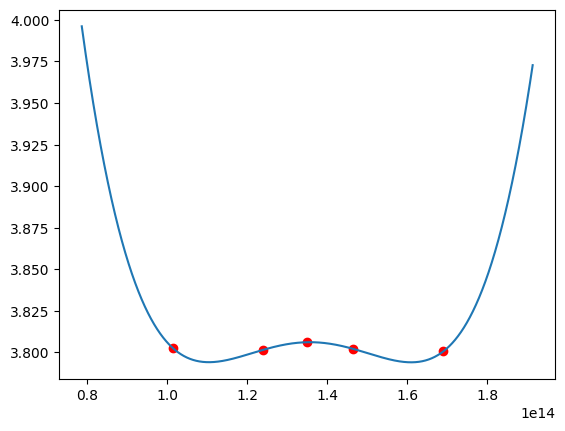

In [733]:
plt.plot(min_frequenz_total,n_array, "ro")
plt.plot(frequenz_20_no_edge,polynomial(frequenz_20_no_edge,*params_fit))

# Für 80C

In [734]:
cutoff_80 = find_nearest(frequenz, 0.8e14)
cutup_80 = find_nearest(frequenz, 2.0e14)
ends_80 = 600
frequenz_80_cut = frequenz[cutoff_80:cutup_80]
frequenz_80_no_edge = frequenz[cutoff_80+ends_80:cutup_80-ends_80]
data_J13_80 = data[10][::-1][cutoff_80:cutup_80]
data_J13_80_no_edge = data_J13_80[ends_80:-ends_80]
J13_80_smooth, J13_80_smoothed_out = flatten(data_J13_80, N = 1200)
J13_80_smooth_no_edge = J13_80_smooth[ends_80:-ends_80]
J13_80_smoothed_out_no_edge = J13_80_smoothed_out[ends_80:-ends_80]


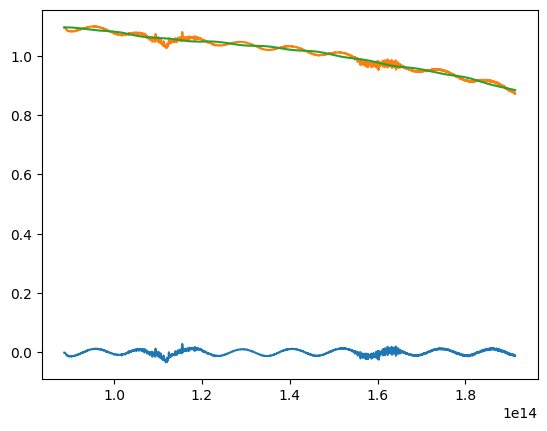

In [735]:
plt.plot(frequenz_80_no_edge, J13_80_smoothed_out_no_edge)
plt.plot(frequenz_80_no_edge, data_J13_80_no_edge)
plt.plot(frequenz_80_no_edge, J13_80_smooth_no_edge)


In [736]:
min_frequenz_80_total = []
min_absorption_80_total = []

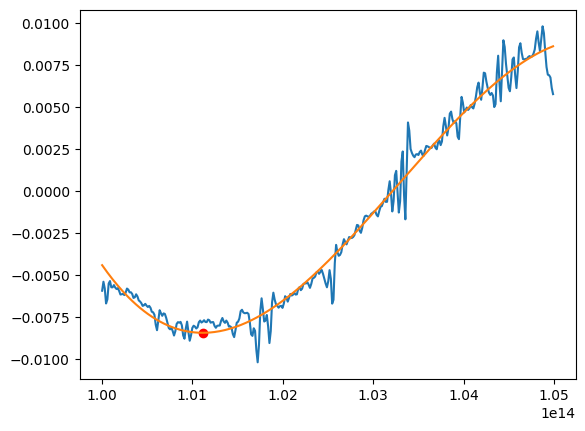

In [737]:
min_frequenz_80_first, min_absorption_80_first = fit_individually(1e14,1.05e14,frequenz_80_no_edge,J13_80_smoothed_out_no_edge)

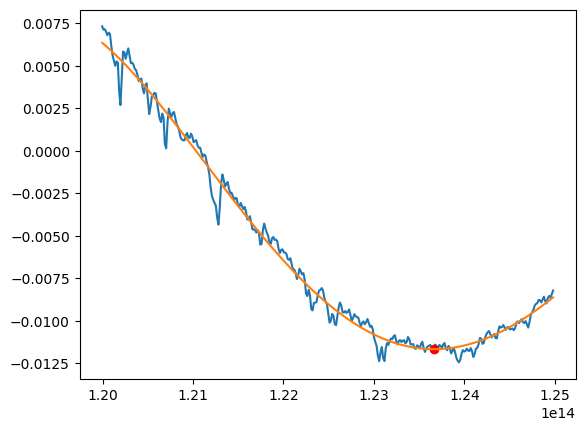

In [738]:
min_frequenz_80_second, min_absorption_80_second = fit_individually(1.2e14,1.25e14,frequenz_80_no_edge,J13_80_smoothed_out_no_edge)

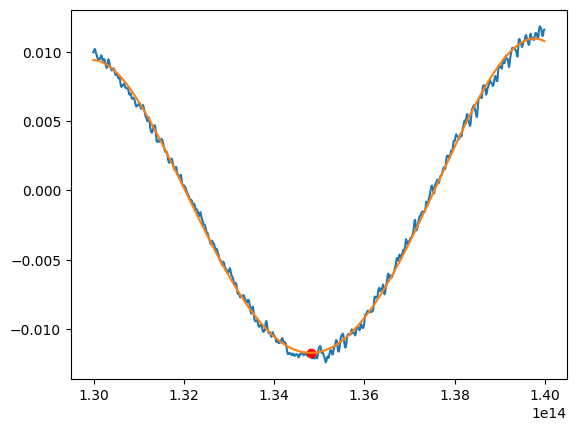

In [739]:
min_frequenz_80_third, min_absorption_80_third = fit_individually(1.3e14,1.4e14,frequenz_80_no_edge,J13_80_smoothed_out_no_edge)

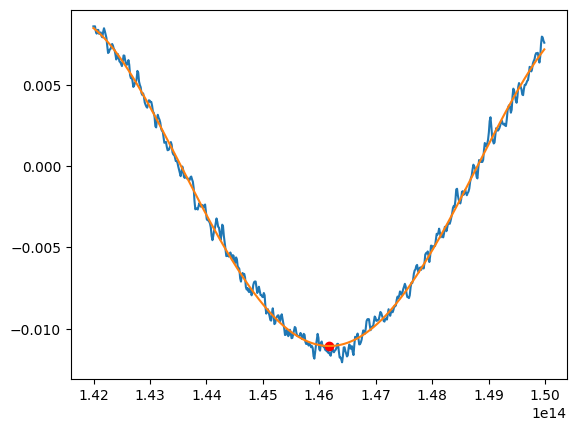

In [740]:
min_frequenz_80_fourth, min_absorption_80_fourth= fit_individually(1.42e14,1.5e14,frequenz_80_no_edge,J13_80_smoothed_out_no_edge)

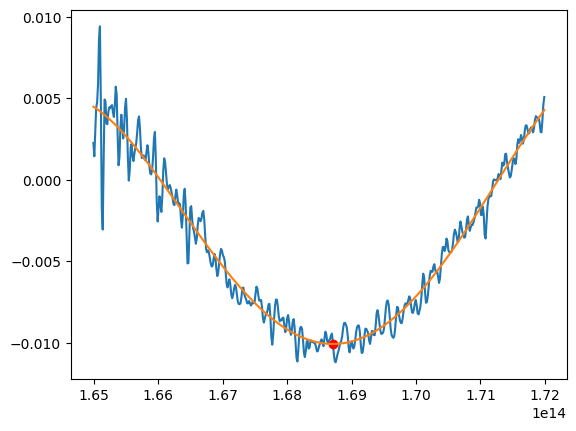

In [741]:
min_frequenz_80_fifth, min_absorption_80_fifth = fit_individually(1.65e14,1.72e14,frequenz_80_no_edge,J13_80_smoothed_out_no_edge)

In [742]:
min_frequenz_80_total = [min_frequenz_80_first[0], min_frequenz_80_second[0], min_frequenz_80_third[0], min_frequenz_80_fourth[0], min_frequenz_80_fifth[0]]
min_absorption_80_total = [min_absorption_80_first[0], min_absorption_80_second[0] , min_absorption_80_third[0],min_absorption_80_fourth[0], min_absorption_80_fifth[0]]

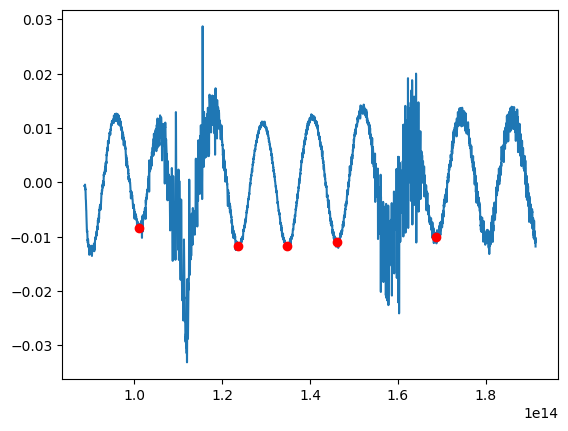

In [743]:
plt.plot(frequenz_80_no_edge,J13_80_smoothed_out_no_edge)
plt.plot(min_frequenz_80_total,min_absorption_80_total, "ro")

In [744]:
m_array_80_total = calculate_m(min_frequenz_80_total)
m_array_80_total

[4.483974364675575, 11.095979232288617, 11.865139939931506, 6.486209114456938]

In [745]:
m_array_clean_80 = np.arange(9,16)
m_array_clean_80 = np.delete(m_array_clean_80, [1,5])
m_array_clean_80

array([ 9, 11, 12, 13, 15])

In [746]:
n_array_80 = []
for i in range(0,len(m_array_clean_80)):
    n_array_80.append(polynomial(min_frequenz_80_total[i],*params_fit))
n_array_80

[3.8032591065883707,
 3.8012959372905506,
 3.8060901179958364,
 3.8022982209251897,
 3.8000714860023947]

In [747]:
l_array_80 = []
for i in range(0,len(m_array_clean_80)):
    l_array_80.append(länge(m_array_clean_80[i],n_array_80[i],min_frequenz_80_total[i]))

l_array_80

[3.5079992950285833e-06,
 3.5075317468096797e-06,
 3.5056405891273015e-06,
 3.506071235028166e-06,
 3.507131452346387e-06]

# Für 160C

In [748]:
cutoff_160 = find_nearest(frequenz, 0.8e14)
cutup_160 = find_nearest(frequenz, 2.0e14)
ends_160 = 600
frequenz_160_cut = frequenz[cutoff_160:cutup_160]
frequenz_160_no_edge = frequenz[cutoff_160+ends_160:cutup_160-ends_160]
data_J13_160 = data[9][::-1][cutoff_160:cutup_160]
data_J13_160_no_edge = data_J13_160[ends_160:-ends_160]
J13_160_smooth, J13_160_smoothed_out = flatten(data_J13_160, N = 1200)
J13_160_smooth_no_edge = J13_160_smooth[ends_160:-ends_160]
J13_160_smoothed_out_no_edge = J13_160_smoothed_out[ends_160:-ends_160]

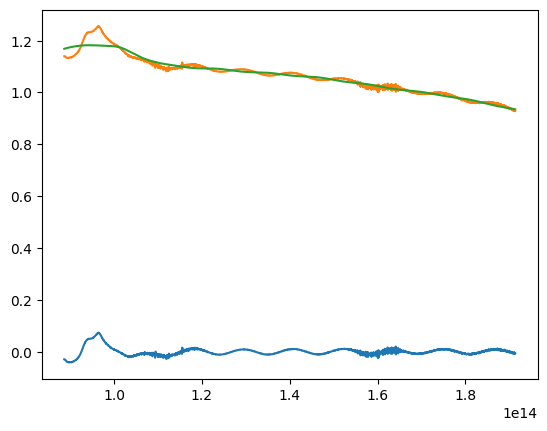

In [749]:
plt.plot(frequenz_160_no_edge, J13_160_smoothed_out_no_edge)
plt.plot(frequenz_160_no_edge, data_J13_160_no_edge)
plt.plot(frequenz_160_no_edge, J13_160_smooth_no_edge)

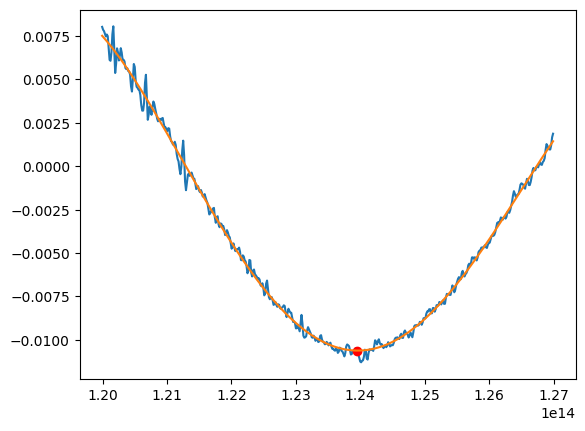

In [750]:
min_frequenz_160_first, min_absorption_160_first = fit_individually(1.2e14,1.27e14,frequenz_160_no_edge,J13_160_smoothed_out_no_edge)

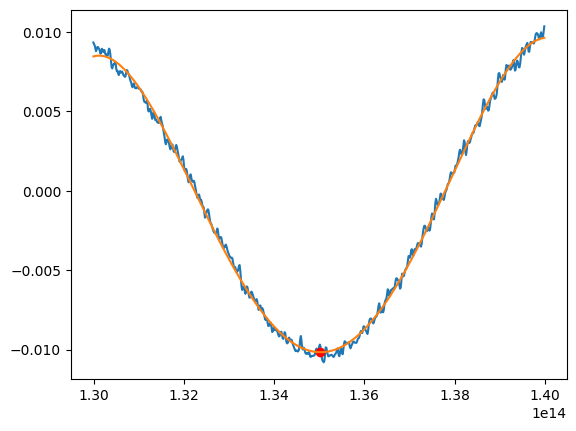

In [751]:
min_frequenz_160_second, min_absorption_160_second = fit_individually(1.3e14,1.4e14,frequenz_160_no_edge,J13_160_smoothed_out_no_edge)

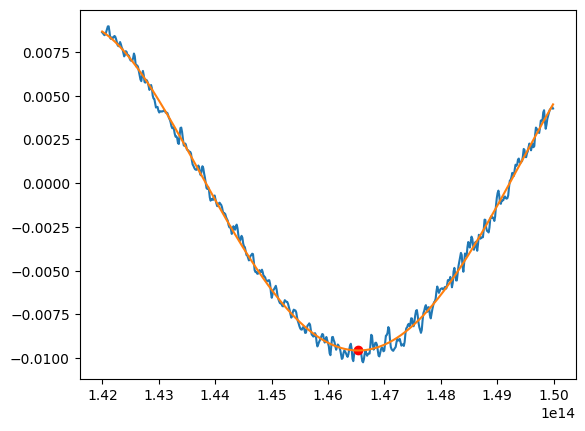

In [752]:
min_frequenz_160_third, min_absorption_160_third = fit_individually(1.42e14,1.5e14,frequenz_160_no_edge,J13_160_smoothed_out_no_edge)

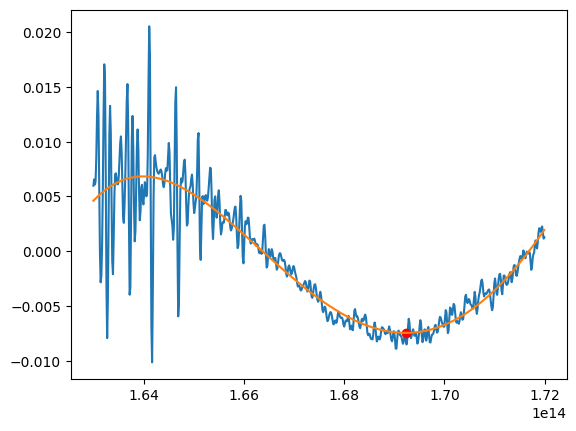

In [753]:
min_frequenz_160_fourth, min_absorption_160_fourth= fit_individually(1.63e14,1.72e14,frequenz_160_no_edge,J13_160_smoothed_out_no_edge)

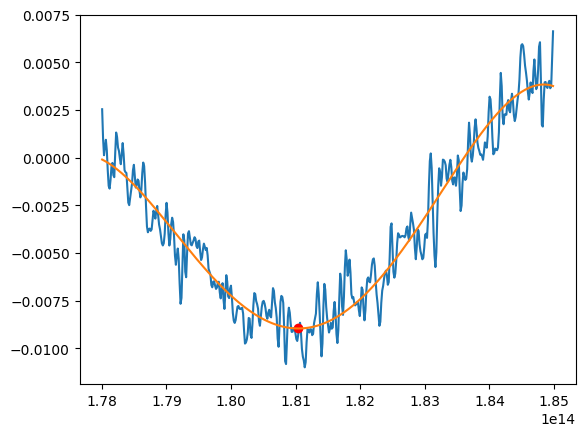

In [754]:
min_frequenz_160_fifth, min_absorption_160_fifth = fit_individually(1.78e14,1.85e14,frequenz_160_no_edge,J13_160_smoothed_out_no_edge)

In [755]:
min_frequenz_160_total = [min_frequenz_160_first[0], min_frequenz_160_second[0], min_frequenz_160_third[0], min_frequenz_160_fourth[0], min_frequenz_160_fifth[0]]
min_absorption_160_total = [min_absorption_160_first[0], min_absorption_160_second[0] , min_absorption_160_third[0],min_absorption_160_fourth[0], min_absorption_160_fifth[0]]

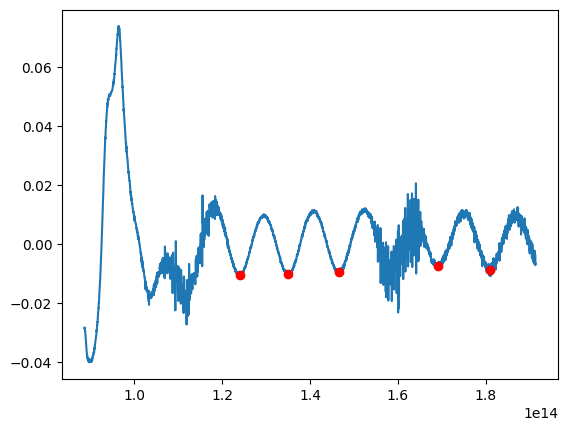

In [756]:
plt.plot(frequenz_160_no_edge,J13_160_smoothed_out_no_edge)
plt.plot(min_frequenz_160_total,min_absorption_160_total, "ro")

In [757]:
m_array_160 =  calculate_m(min_frequenz_160_total)
m_array_160

[11.19451698613858, 11.734924617377796, 6.456687897987366, 14.329253376226283]

In [762]:
m_array_clean_160 = np.arange(11,17)
m_array_clean_160 = np.delete(m_array_clean_160,3)
m_array_clean_160

array([11, 12, 13, 15, 16])

In [763]:
n_array_160= []
for i  in range(len(m_array_clean_160)):
    n_array_160.append((polynomial(min_frequenz_160_total[i],*params_fit)))
n_array_160

[3.8014976961993474,
 3.806102241175262,
 3.802058122185054,
 3.8010350411726357,
 3.8536272370207456]

In [764]:
l_array_160 = []
for i in range(0,len(m_array_clean_160)):
    l_array_160.append(länge(m_array_clean_160[i],n_array_160[i],min_frequenz_160_total[i]))

l_array_160

[3.499165191192651e-06,
 3.499999999999999e-06,
 3.497645378421321e-06,
 3.495460413555985e-06,
 3.4376989504044044e-06]